# MultiEval Confidence-aware Example

This notebook demonstrates a basic parameter sweep with LensKits `MultiEval` class.

## Setup

We first need to import our libraries.

In [93]:
import sys
sys.path.insert(0,'C:\\Users\\Jacob\\Documents\\GitHub\\lenskit_confidence')

In [94]:
#from lenskit.batch import MultiEval
#from lenskit.crossfold import partition_users, SampleN
#from lenskit.algorithms import user_knn #basic, als, item_knn, user_knn
#from lenskit.datasets import MovieLens
#from lenskit import topn, util #, metrics
from lenskit.metrics import predict
import pandas as pd
import matplotlib.pyplot as plt

from lenskit.batch_ca import MultiEval
from lenskit.algorithms_ca import user_knn_ca, Recommender
from lenskit.metrics.predict import rmse
from lenskit import datasets
from lenskit.datasets import MovieLens
from lenskit import crossfold as xf
from lenskit import topn, datasets, batch_ca # *not* batch 
from lenskit import topn, util #, metrics
from lenskit.crossfold import partition_users, SampleN, partition_rows
import pandas as pd
import logging


Progress bars are useful:

In [3]:
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

C:\Users\Jacob\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


It takes a little while to run things, and can get kinda quiet in here. Let's set up logging so we can see the logging output in the notebook's message stream:

In [4]:
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


Then set up the data access.

In [98]:
#mlsmall = MovieLens('../data/ml-latest-small')
mlsmall = MovieLens('../data/ml-1m')
#mlsmall = MovieLens('../data/ml-10m')
#mlsmall = MovieLens('../data/ml-20m')

## Experiment

We're going to run our evaluation and store its output in the `my-eval` directory, generating 20-item recommendation lists::

In [99]:
eval = MultiEval('my-eval', predict = True, recommend = 15)

We're going to use a 5-fold cross-validation setup.  We save the data into a list in memory so we have access to the test data later.  In a larger experiment, you might write the partitions to disk and pass the file names to `add_datasets`.

In [100]:
pairs = list(partition_users(mlsmall.ratings, 5, SampleN(5)))
#pairs = (partition_users(mlsmall.ratings, 5, SampleN(5)))
pairs

[   INFO] lenskit.crossfold partitioning 1000209 rows for 6040 users into 5 partitions
[   INFO] lenskit.crossfold fold 0: selecting test ratings
[   INFO] lenskit.crossfold fold 0: partitioning training data
[   INFO] lenskit.crossfold fold 1: selecting test ratings
[   INFO] lenskit.crossfold fold 1: partitioning training data
[   INFO] lenskit.crossfold fold 2: selecting test ratings
[   INFO] lenskit.crossfold fold 2: partitioning training data
[   INFO] lenskit.crossfold fold 3: selecting test ratings
[   INFO] lenskit.crossfold fold 3: partitioning training data
[   INFO] lenskit.crossfold fold 4: selecting test ratings
[   INFO] lenskit.crossfold fold 4: partitioning training data


[TTPair(train=         Unnamed: 0  user  item  rating  timestamp
 0                 1     1  1193     5.0  978300760
 1                 2     1   661     3.0  978302109
 2                 3     1   914     3.0  978301968
 3                 4     1  3408     4.0  978300275
 4                 5     1  2355     5.0  978824291
 ...             ...   ...   ...     ...        ...
 1000204     1000205  6040  1091     1.0  956716541
 1000205     1000206  6040  1094     5.0  956704887
 1000206     1000207  6040   562     5.0  956704746
 1000207     1000208  6040  1096     4.0  956715648
 1000208     1000209  6040  1097     4.0  956715569
 
 [994169 rows x 5 columns], test=         Unnamed: 0  user  item  rating  timestamp
 29               30     1   745     3.0  978824268
 52               53     1  1246     4.0  978302091
 11               12     1   938     4.0  978301752
 28               29     1  1545     4.0  978824139
 35               36     1   783     4.0  978824291
 ...             

In [101]:
eval.add_datasets(pairs, name = 'ML-Small')

In [102]:
nhbr_range = [10, 25, 50, 75] # 100] #, 100] #, 200]

In [ ]:
#eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'weighted-average') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'ItemKNN-Weighted')

#eval.add_algorithms([item_knn.ItemItem(nnbrs = f, aggregate = 'sum') for f in nhbr_range], 
#                    attrs = ['nnbrs'], name = 'ItemKNN-Sum')

In [103]:
eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-Average') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'weighted-average', 
                                            variance_estimator = 'standard-deviation-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-Weighted') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-jackknife-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-JK-Average') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'weighted-average', 
                                            variance_estimator = 'standard-deviation-jackknife-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-JK-Weighted') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-bootstrap-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-BS-Average') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'weighted-average', 
                                            variance_estimator = 'standard-deviation-bootstrap-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-BS-Weighted') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'average', 
                                            variance_estimator = 'standard-deviation-bootstrap-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-BS-Average') 

eval.add_algorithms([user_knn_ca.UserUserCA(nnbrs = f, aggregate = 'weighted-average', 
                                            variance_estimator = 'standard-deviation-bootstrap-weighted-average') for f in nhbr_range], 
                    attrs = ['nnbrs'], name = 'UserKNN-CA-BS-Weighted') 

# standard-deviation-average
# standard-deviation-weighted-average
# standard-deviation-jackknife-average
# standard-deviation-jackknife-weighted-average
# standard-deviation-bootstrap-average
# standard-deviation-bootstrap-weighted-average

And finally, we will run the experiment!

In [ ]:
eval.run(progress = tqdm)

[   INFO] lenskit.batch_ca._multi_ca starting run 1: UserUserCA(nnbrs=10, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting UserUserCA(nnbrs=10, min_sim=0) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm UserUserCA(nnbrs=10, min_sim=0) on 994169 ratings
[   INFO] lenskit.algorithms_ca.user_knn_ca calling fit in user_knn
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm UserUserCA(nnbrs=10, min_sim=0) in  426ms
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/UserUserCA(nnbrs=10, min_sim=0)
[   INFO] lenskit.sharing.shm serialized TopN/UserUserCA(nnbrs=10, min_sim=0) to 1176 pickle bytes with 13 buffers of 28104104 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  35ms)
[   INFO] lenskit.batc

[   INFO] lenskit.batch_ca._recommend_ca beginning of recommend function in _recommend_ca (1)
[   INFO] lenskit.batch_ca._recommend_ca adapting algorithm in  _recommend_ca
[   INFO] lenskit.sharing.shm serialized TopN/UserUserCA(nnbrs=75, min_sim=0) to 1176 pickle bytes with 13 buffers of 28104104 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/UserUserCA(nnbrs=75, min_sim=0) for 1208 users (n_jobs=None)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 52.54s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 53.12s
[   INFO] lenskit.batch_ca._multi_ca run 4: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 4: UserUserCA(nnbrs=75, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._mu

[   INFO] lenskit.algorithms_ca.user_knn_ca calling fit in user_knn
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm UserUserCA(nnbrs=75, min_sim=0) in  459ms
[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/UserUserCA(nnbrs=75, min_sim=0)
[   INFO] lenskit.sharing.shm serialized TopN/UserUserCA(nnbrs=75, min_sim=0) to 1194 pickle bytes with 13 buffers of 28104104 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  41ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 24.26s
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 24.85s
[   INFO] lenskit.batch_ca._multi_ca run 8: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 

[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._recommend_ca  (2) recommending with TopN/UserUserCA(nnbrs=50, min_sim=0) for 1208 users (n_jobs=None)
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 1m46.24s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 1m46.88s
[   INFO] lenskit.batch_ca._multi_ca run 11: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 11: UserUserCA(nnbrs=50, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca starting run 12: UserUserCA(nnbrs=75, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting UserUserCA(nnbrs=75, min_sim=0) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm UserUserCA(nnbrs=75, min_sim=0) on 994169 ratings
[   INFO] lenskit.algorith

[   INFO] lenskit.batch_ca._multi_ca generating 6040 predictions for TopN/UserUserCA(nnbrs=50, min_sim=0)
[   INFO] lenskit.sharing.shm serialized TopN/UserUserCA(nnbrs=50, min_sim=0) to 1204 pickle bytes with 13 buffers of 28104104 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.batch_ca._predict_ca generating 6040 predictions for 1208 users (setup took  34ms)
[   INFO] lenskit.batch_ca._predict_ca generated 6040 predictions for 1208 users in 22.70s
[   INFO] lenskit.batch_ca._multi_ca generated predictions in 23.38s
[   INFO] lenskit.batch_ca._multi_ca run 15: writing results to my-eval\predictions.parquet
[   INFO] lenskit.batch_ca._multi_ca generating recommendations for 1208 users for TopN/UserUserCA(nnbrs=50, min_sim=0)
[   INFO] lenskit.batch_ca._recommend_ca beginning of recommend function in _recommend_ca (1)
[   INFO] lenskit.batch_ca._recommend_ca adapting algorithm in  _recommend_ca
[   INFO] lenskit.sharing.shm serialized

[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] numexpr.utils NumExpr defaulting to 4 threads.
[   INFO] lenskit.batch_ca._recommend_ca recommended for 1208 users in 2m51.41s
[   INFO] lenskit.batch_ca._multi_ca generated recommendations in 2m52.15s
[   INFO] lenskit.batch_ca._multi_ca run 18: writing results to my-eval\recommendations.parquet
[   INFO] lenskit.batch_ca._multi_ca finished run 18: UserUserCA(nnbrs=25, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca starting run 19: UserUserCA(nnbrs=50, min_sim=0) on ML-Small:1
[   INFO] lenskit.batch_ca._multi_ca adapting UserUserCA(nnbrs=50, min_sim=0) into a recommender
[   INFO] lenskit.batch_ca._multi_ca training algorithm UserUserCA(nnbrs=50, min_sim=0) on 994169 ratings
[   INFO] lenskit.algorithms_ca.user_knn_ca calling fit in user_knn
[   INFO] lenskit.algorithms_ca.basic_ca trained unrated candidate selector for 994169 ratings
[   INFO] lenskit.batch_ca._multi_ca trained algorithm UserUserCA(nnb

## Analysis

Now that the experiment is run, we can read its outputs.

First the run metadata:

In [60]:
runs = pd.read_csv('my-eval/runs.csv')
runs.set_index('RunId', inplace = True)
runs.head()

,DataSet,Partition,AlgoClass,AlgoStr,name,nnbrs,TrainTime,PredTime,RecTime
RunId,,,,,,,,,
1,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=10, min_sim=0)",UserKNN-CA-Average,10,0.436852,21.160756,43.575914
2,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=25, min_sim=0)",UserKNN-CA-Average,25,0.422573,19.869187,46.634081
3,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=50, min_sim=0)",UserKNN-CA-Average,50,0.470888,19.722286,50.281543
4,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=100, min_sim=0)",UserKNN-CA-Average,100,0.408256,19.614458,53.890825
5,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=10, min_sim=0)",UserKNN-CA-Weighted,10,0.482748,20.324234,44.622494


This describes each run - a data set, partition, and algorithm combination.  To evaluate, we need to get the actual recommendations, and combine them with this:

In [67]:
recs = pd.read_parquet('my-eval/recommendations.parquet')
#del recs['RunId']
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId
0,682,6.960536,7,0.125594,3.0,1,1
1,2503,5.338021,7,0.210376,2.0,2,1
2,2999,3.433282,7,0.250719,2.0,3,1
3,2578,3.409142,7,0.064737,2.0,4,1
4,1002,2.872314,7,0.288184,4.0,5,1


In [68]:
recs['var'].describe()

count    1.449480e+06
mean     4.641372e-01
std      4.593021e-01
min      3.468303e-06
25%      3.795821e-02
50%      3.419159e-01
75%      1.000000e+00
max      5.043078e+00
Name: var, dtype: float64

In [69]:
recs['score'] = recs['prediction']

In [70]:
recs = recs[['item', 'score', 'user','rank','RunId']]
recs.head()

,item,score,user,rank,RunId
0,682,6.960536,7,1,1
1,2503,5.338021,7,2,1
2,2999,3.433282,7,3,1
3,2578,3.409142,7,4,1
4,1002,2.872314,7,5,1


Getting the predictions...

In [71]:
preds = pd.read_parquet('my-eval/predictions.parquet')
#del recs['RunId']
preds

,RunId,user,item,rating,prediction
0,1,7,648,4.0,4.016363
1,1,7,480,4.0,3.966319
2,1,7,1580,4.0,4.279135
3,1,7,589,5.0,4.935996
4,1,7,1270,4.0,4.760172
...,...,...,...,...,...
483195,9,6040,3524,1.0,3.426890
483196,9,6040,1077,5.0,4.066970
483197,9,6040,246,5.0,4.340378
483198,9,6040,2391,4.0,4.378877


We're going to compute per-(run,user) evaluations of the recommendations *before* combining with metadata. 

In order to evaluate the recommendation list, we need to build a combined set of truth data. Since this is a disjoint partition of users over a single data set, we can just concatenate the individual test frames:

In [72]:
truth = pd.concat((p.test for p in pairs), ignore_index = True)

#truth['score'] = truth['rating']
truth.head()

,Unnamed: 0,user,item,rating,timestamp
0,524,7,648,4.0,978234737
1,552,7,480,4.0,978234607
2,548,7,1580,4.0,978234842
3,530,7,589,5.0,978234786
4,540,7,1270,4.0,978234581


Now we can set up an analysis and compute the results.

In [73]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg) # precision, recall, recip_rank, dcg, ndcg
rla.add_metric(topn.precision)
#rla.add_metric(predict.rmse)
raw_ndcg = rla.compute(recs, truth)
raw_ndcg.head()

[   INFO] lenskit.topn analyzing 1449480 recommendations (30200 truth rows)
[   INFO] lenskit.topn using rec key columns ['RunId', 'user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn collecting truth data
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.sharing.shm serialized <lenskit.topn._RLAJob object at 0x00000244C387D1F0> to 2634822 pickle bytes with 24163 buffers of 47228960 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.topn measured 96632 lists in 2m33.51s


nrecs  ndcg  precision
RunId user                        
1     7      15.0   0.0        0.0
      10     15.0   0.0        0.0
      11     15.0   0.0        0.0
      24     15.0   0.0        0.0
      25     15.0   0.0        0.0

Next, we need to combine this with our run data, so that we know what algorithms and configurations we are evaluating:

In [74]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg = raw_ndcg.join(runs[['name', 'nnbrs']], on = 'RunId') # 
ndcg.head()

nrecs  ndcg  precision                name  nnbrs
RunId user                                                   
1     7      15.0   0.0        0.0  UserKNN-CA-Average     10
      10     15.0   0.0        0.0  UserKNN-CA-Average     10
      11     15.0   0.0        0.0  UserKNN-CA-Average     10
      24     15.0   0.0        0.0  UserKNN-CA-Average     10
      25     15.0   0.0        0.0  UserKNN-CA-Average     10

We can compute the overall average performance for each algorithm configuration - fillna makes the group-by happy with Popular's lack of a feature count:

In [75]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()

<ipython-input-75-9f49e897c919>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()


ndcg  precision
name                   nnbrs                     
UserKNN-CA-Average     10     0.010326   0.005773
                       25     0.007703   0.004558
                       50     0.006424   0.004073
                       100    0.005583   0.003675
UserKNN-CA-JK-Average  10     0.011089   0.006258
                       25     0.008366   0.004868
                       50     0.007152   0.004492
                       100    0.006257   0.004062
UserKNN-CA-JK-Weighted 10     0.005139   0.002793
                       25     0.004178   0.002351
                       50     0.003691   0.002197
                       100    0.003012   0.001899
UserKNN-CA-Weighted    10     0.004997   0.002782
                       25     0.004047   0.002274
                       50     0.003448   0.002131
                       100    0.002799   0.001799

Now, we can plot this:

Text(0, 0.5, 'nDCG')

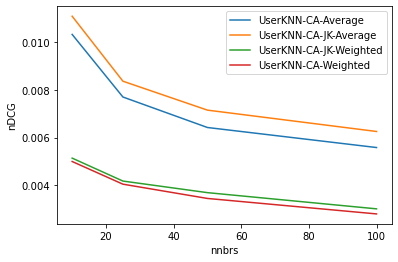

In [76]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['ndcg'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['ndcg'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('nDCG')

Text(0, 0.5, 'Precision')

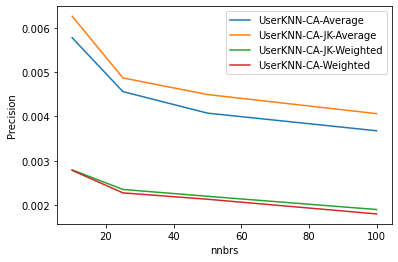

In [77]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['precision'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['precision'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('Precision')

In [ ]:
#truth # user, item, rating, timestamp - 3355
#preds # RunId, user, item rating, prediction

### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
pred_acc = preds.join(runs[['name', 'nnbrs']], on = 'RunId')
pred_acc.head()


#from lenskit.metrics.predict import rmse
#rmse(preds['prediction'], preds['rating'])

In [ ]:
pred_acc.loc[pred_acc['prediction'] > 5,'prediction'] = 5
pred_acc.loc[pred_acc['prediction'] < 1,'prediction'] = 1

pred_acc['se'] = (pred_acc['rating'] - pred_acc['prediction'])**2


#pred_acc.groupby(['AlgoClass', 'nnbrs'])['rating','prediction'])


#ndcg.fillna(0).groupby(['AlgoClass', 'nnbrs'])['ndcg','precision'].mean()

In [ ]:
import numpy as np
#from np import sqrt
np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean())

In [ ]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
knn_pred_scores = np.sqrt(pred_acc.groupby(['name', 'nnbrs'])['se'].mean()).reset_index()
knn_pred_scores.head()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in knn_pred_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['se'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('RMSE')